# 接續image_process_view_csv.ipynb

# 接續GET_MASK_2022_04_16_12_36

# 訓練模組

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
np.random.choice(np.arange(10),10)

array([8, 0, 6, 2, 0, 6, 4, 0, 1, 1])

In [ ]:
input_size = [256, 256, 3]

def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    '''
    images_path/masks_path: Images/Masks folder directory.
    images_ids/mask_ids: Ids for '.jpg' images/masks.
    img_size: Generated imgs/masks size.
    
    returns: batch of randomly-selected car&mask images value-scaled (0 -> 1). 
    '''
    data_size = len(image_ids)
    while True:
        #Choose random indice for later picking.
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            #Pick a random id for car&mask images.
            img_id, mask_id = image_ids[i], mask_ids[i]
            #Load/resize images.
            img = load_img(images_path +"\\" + img_id, target_size=img_size) 
            mask = load_img(masks_path +"\\" + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            #Add to the batch data.
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [ ]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
#imgPath = r"C:\Users\sky66\fiftyone\coco-2017\new"
#maskPath = r"C:\Users\sky66\fiftyone\coco-2017\mask"

imgPath = r"C:\Users\sky66\Desktop\i"
maskPath = r"C:\Users\sky66\Desktop\m"

# 放mask
masks = list(os.listdir(maskPath))

# 放新圖片
images = list(os.listdir(imgPath))

masks = sorted(masks)
images = sorted(images)

train = int(len(masks)*0.8)
val = len(images)-train

train_img = images[0:train]
train_mask = masks[0:train]

val_img = images[train:]
val_mask = masks[train:]

In [ ]:
modelPath = r'C:\Users\sky66\Desktop\my_model'

uNet = tf.keras.models.load_model(modelPath, custom_objects={"dice_coef":dice_coef, "dice_loss":dice_loss, "bce_dice_loss":bce_dice_loss})
uNet.compile(optimizer=RMSprop(learning_rate=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

In [ ]:
#Prepare callbacks
LR_callback = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=10, factor=.2, min_lr=.00001)
EarlyStop_callback = EarlyStopping(monitor='val_loss',patience=100, restore_best_weights=True)

In [ ]:
#Perpare data generators.
batch_size = 5
train_gen = data_generator(imgPath, maskPath, train_img, train_mask, batch_size=batch_size)
val_gen = data_generator(imgPath, maskPath, val_img, val_mask, batch_size=batch_size)

In [ ]:
history = uNet.fit(train_gen, steps_per_epoch=int(train/batch_size),
                             epochs=3, validation_data=val_gen,
                             validation_steps=int(val/batch_size),
                             callbacks=[LR_callback, EarlyStop_callback])

In [ ]:
uNet.save(modelPath)

In [ ]:
# 2022_04_17_02_03 調整為訓練灰階圖片

In [ ]:
import os
import cv2
import concurrent.futures

In [ ]:
def stored(p, e):
    fil = p+"\\"+e
    a = cv2.imread(fil, cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(fil, a)
    
def save(path):
    tar = os.listdir(path)
    tar = list(tar)
    Max = 30
    for n in range(0,len(tar),Max):
        with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
            for i in tar[n:n+Max]:
                executor.submit(stored, path, i) 
                
p = r"C:\Users\sky66\fiftyone\coco-2017\new"

In [ ]:
save(p)

# 進行偵測

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

1 Physical GPUs, 1 Logical GPUs


In [9]:
def cv2_to_plt(img_np):
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    img_np = img_np/255
    return img_np

def plt_to_cv2(img_np):
    return cv2.cvtColor((img_np*255).astype("uint8"), cv2.COLOR_RGB2BGR)
    
def pred(img_path):    
    # load
    img_np = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path)
    img_np = cv2.cvtColor (img_np, cv2.COLOR_GRAY2BGR)
    width = img.shape[1]
    height = img.shape[0]
    img_np = cv2.resize(img_np, (256,256))
    
    # use to predict
    img_np = cv2_to_plt(img_np)
    img_np = np.expand_dims(img_np, 0)
    
    # predict
    pred_mask = uNet.predict(img_np)
    pred_mask = pred_mask[0]
    
    # process image
    # mask is GRAYSCALE
    pred_mask = pred_mask*255
    pred_mask = cv2.resize(pred_mask, (width,height))
    pred_mask = pred_mask/255
    pred_mask = np.reshape(pred_mask,(height,width,1))
    img = cv2_to_plt(img)
      
    return pred_mask*255, plt_to_cv2(img), plt_to_cv2(img*pred_mask)

def view(img_path):
    pred_mask, img, res = pred(img_path)
    img = cv2_to_plt(img)
    pred_mask /= 255
    # view
    fig, ax = plt.subplots(1, 3, figsize=(80,80))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(pred_mask, cmap='gray')
    ax[1].axis('off')
    # ax[2].imshow(pred_img*np.where(pred_mask>0.1, 1, 0))
    ax[2].imshow(img*pred_mask)
    ax[2].axis('off')
    plt.show()      
    
def stored(path):
    store = r"C:\Users\sky66\Desktop\predict"
    name = path.split("\\")[-1].split(".")[0]
    a,b,c = pred(path)
    cv2.imwrite(store+"\\"+name+"_image.jpg", b)
    cv2.imwrite(store+"\\"+name+"_mask.jpg", a)   
    cv2.imwrite(store+"\\"+name+"_predict.jpg", c)        

In [10]:
modelPath = r'C:\Users\sky66\Desktop\my_model'
uNet = tf.keras.models.load_model(modelPath, custom_objects={"dice_coef":dice_coef, "dice_loss":dice_loss, "bce_dice_loss":bce_dice_loss})

In [ ]:
path = r"C:\Users\sky66\Desktop\Model\predict"+"\\"
for i in os.listdir(path):
    if i.split(".")[0].split("_")[-1] != "image":
        continue
    f = path+i
    view(f)
    input("Press Enter")

# 重新建立模組

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img
import os
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import random

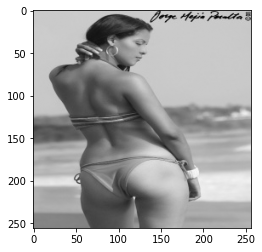

In [45]:
s = cv2.imread(r"C:\Users\sky66\Desktop\i\06bfefab10984000.jpg")/255
plt.imshow(s)
s = s.reshape(1,256,256,3)

In [46]:
s.shape

(1, 256, 256, 3)

In [58]:
K.clear_session()

In [51]:
input_shape=(256, 256, 1)

In [30]:
Input(shape=input_shape)

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_1')>

In [49]:
x  = Conv2D(32, (3, 3), padding='same')(s)

In [50]:
x.numpy().shape

(1, 256, 256, 32)

In [59]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

1 Physical GPUs, 1 Logical GPUs


In [60]:
# https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge/blob/master/model/u_net.py
def get_unet_256(input_shape=(256, 256, 1),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

    return model

In [61]:
model = get_unet_256()

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [63]:
modelPath = r'C:\Users\sky66\Desktop\my_model'
model.save(modelPath)

INFO:tensorflow:Assets written to: C:\Users\sky66\Desktop\my_model\assets
